In [1]:
# ===== load files from google drive ===== #
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r ./gdrive/MyDrive/AI_Final/* .

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import cv2
import os
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import random

In [13]:
##### read data #####

#pname = "data/training/skeleton"
pname = "data/training/no_skeleton"
paths = os.listdir(pname)

##############################################
#
# data: skeleton / no_skeleton
# number of classes: 10
# number of images in each class: 150
# training : testing = 0.8 : 0.2
#
###############################################

x_train = np.zeros((1200, 3, 150, 150))
y_train = np.zeros(1200)
x_test = np.zeros((300, 3, 150, 150))
y_test = np.zeros(300)
train_idx = 0
test_idx = 0
cnt = [ 0 for i in range(11)]

for label in paths:
  if label == ".DS_Store": continue

  img_paths = os.listdir(pname+"/"+label)
  #random.shuffle(img_paths)

  label = int(label)

  for img_path in img_paths:
    img = cv2.imread(pname+"/"+str(label)+"/"+img_path, cv2.IMREAD_COLOR)

    #print(len(img_paths))
    dim = (150, 150)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # resize image to 150*150
    img = np.transpose(img)
    
    if cnt[label] < 120:
      x_train[train_idx] = img
      y_train[train_idx] = label
      train_idx += 1
    elif cnt[label] < 150:
      x_test[test_idx] = img
      y_test[test_idx] = label
      test_idx += 1

    cnt[label] += 1
  
  
  
  #cv2_imshow(img)

In [14]:
### Hyperparameter
lr = 0.0005
epochs = 30
batch = 8

In [15]:
### Data Preparation
x_train = torch.from_numpy(np.array(x_train))
y_train = torch.from_numpy(np.array(y_train)).type(torch.LongTensor)
x_test = torch.from_numpy(np.array(x_test))
y_test = torch.from_numpy(np.array(y_test)).type(torch.LongTensor)
#print(x_train.shape)
#print(y_train.shape)

train_set = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_set , batch_size=batch, shuffle=True, num_workers=2)
test_set = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_set , batch_size=batch, shuffle=True, num_workers=2)

In [16]:
### CNN Model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.cnn1 = nn.Conv2d(3, 8, kernel_size=2, stride=2, padding=0)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(8, 32, kernel_size=2, stride=1, padding=0)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc = nn.Linear(10368, 10)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)

    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0),-1)

    out = self.fc(out)
    return out

In [17]:
model = CNN()
print(model)

CNN(
  (cnn1): Conv2d(3, 8, kernel_size=(2, 2), stride=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=10368, out_features=10, bias=True)
)


In [18]:
### main
device = torch.device('cpu')

model = CNN()
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=lr)

train_loss=[]
train_acc=[]
test_acc=[]

print("Start Training")
patience = 2
the_last_loss = 0
trigger_times = 0

for epoch in range(epochs):
  
  # === train ===
  model.train()
  correct = 0
  total = 0
  total_loss = 0

  
  for i, (img, label) in enumerate(train_loader):
    x = img.to(device, dtype = torch.float)
    y = label.to(device, dtype = torch.long)
    output = model(x)
  
    Loss = nn.CrossEntropyLoss()
    loss = Loss(output, y)
    pred = output.argmax(dim=1)

    
    total_loss += loss.item()
    for i in range(y.shape[0]):
      total += 1
      if y[i] == pred[i]: correct += 1      
    
    optim.zero_grad()
    loss.backward()
    optim.step()

  train_acc.append(correct*100/total)
  train_loss.append(total_loss)


  # === test ===
  model.eval()
  correct = 0
  total = 0
  test_loss = 0

  for i, (img, label) in enumerate(test_loader):
    x = img.to(device, dtype = torch.float)
    y = label.to(device, dtype = torch.long)

    output = model(x)
    loss = Loss(output, label)
    pred = output.argmax(dim=1) 

    test_loss += loss.item()
    for i in range(y.shape[0]):
      total += 1
      if y[i] == pred[i]: correct += 1
      
  
  # Save weight
  if epoch != 0 and (correct*100/total) > max(test_acc):
    print("Save !")
    torch.save(model, 'no_skeleton_1.pkl')

  # Print information
  test_acc.append(correct*100/total)
  print("Epoch %d/%d" %(epoch, epochs))
  print("train accuracy: %.3f  train loss %.3f  test accuracy: %.3f" %(train_acc[-1], train_loss[-1], test_acc[-1]))


  # Early stopping
  if total_loss > the_last_loss:
    trigger_times += 1
    if trigger_times >= patience:
      print('Early stopping!\nStart to test process.')
      break
  else:
    patient = 0

  the_last_loss = total_loss


Start Training
Epoch 0/30
train accuracy: 34.000  train loss 2456.830  test accuracy: 57.000
Save !
Epoch 1/30
train accuracy: 78.500  train loss 97.665  test accuracy: 68.667
Save !
Epoch 2/30
train accuracy: 92.417  train loss 35.711  test accuracy: 72.000
Save !
Epoch 3/30
train accuracy: 96.667  train loss 18.111  test accuracy: 73.000
Save !
Epoch 4/30
train accuracy: 99.083  train loss 8.627  test accuracy: 74.333
Save !
Epoch 5/30
train accuracy: 99.000  train loss 7.015  test accuracy: 76.000
Save !
Epoch 6/30
train accuracy: 99.917  train loss 2.495  test accuracy: 76.667
Epoch 7/30
train accuracy: 100.000  train loss 1.296  test accuracy: 76.667
Epoch 8/30
train accuracy: 100.000  train loss 0.593  test accuracy: 76.667
Epoch 9/30
train accuracy: 100.000  train loss 0.433  test accuracy: 76.000
Epoch 10/30
train accuracy: 100.000  train loss 0.320  test accuracy: 76.000
Epoch 11/30
train accuracy: 100.000  train loss 0.253  test accuracy: 76.667
Epoch 12/30
train accuracy: 10

In [12]:
!cp ./*.pkl ./gdrive/MyDrive/AI_Final/

In [9]:
device = torch.device('cpu')
model = torch.load("no_skeleton_1.pkl")
Loss = nn.CrossEntropyLoss()

confusion_matrix=[[0 for j in range(10)] for i in range(10)]

correct = 0
total = 0
test_loss = 0

for i, (img, label) in enumerate(test_loader):
  x = img.to(device, dtype = torch.float)
  y = label.to(device, dtype = torch.long)

  output = model(x)
  loss = Loss(output, label)
  pred = output.argmax(dim=1) 

  test_loss += loss.item()
  for i in range(y.shape[0]):
    confusion_matrix[y[i]][pred[i]] += 1

#print(confusion_matrix)

In [10]:
i = 0
total = 0
for lst in confusion_matrix:
  print(lst, "Accuracy:", round(confusion_matrix[i][i]/30, 2))
  total += confusion_matrix[i][i]
  i += 1

print("Total Accuracy:",total/300)

[27, 0, 0, 0, 1, 1, 0, 0, 1, 0] Accuracy: 0.9
[0, 30, 0, 0, 0, 0, 0, 0, 0, 0] Accuracy: 1.0
[0, 1, 25, 3, 1, 0, 0, 0, 0, 0] Accuracy: 0.83
[0, 0, 5, 22, 1, 0, 1, 0, 1, 0] Accuracy: 0.73
[2, 0, 3, 0, 24, 0, 0, 0, 1, 0] Accuracy: 0.8
[0, 0, 0, 0, 1, 27, 1, 0, 1, 0] Accuracy: 0.9
[0, 0, 1, 0, 0, 3, 23, 1, 2, 0] Accuracy: 0.77
[0, 0, 5, 0, 0, 0, 1, 24, 0, 0] Accuracy: 0.8
[1, 0, 0, 0, 2, 1, 0, 1, 25, 0] Accuracy: 0.83
[0, 0, 0, 0, 0, 0, 0, 0, 0, 30] Accuracy: 1.0
Total Accuracy: 0.8566666666666667


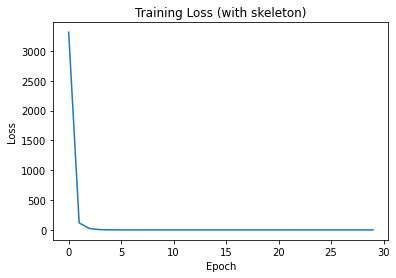

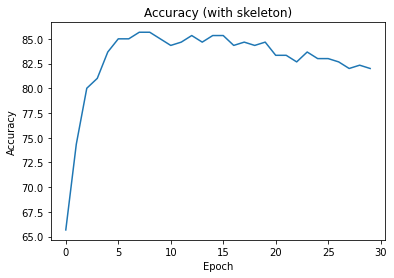

In [11]:
##### plot #####
import matplotlib.pyplot as plt

row = [i for i in range(epochs)]
plt.plot(row, train_loss)
plt.title("Training Loss (with skeleton)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(row, test_acc)
plt.title("Accuracy (with skeleton)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# grasp five image